In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
# from models.deepant import ForecastBasedDataset, DataModule, DeepAnT, ForecastBasedAD
from pytorch_lightning.callbacks import ModelCheckpoint

import pytorch_lightning as pl
import seaborn as sns

from utils import ts_stats, create_sequences
pl.seed_everything(42, workers=True)


df_d = pd.read_csv("../data/ts_d_m.csv", parse_dates=["date"])
df_nd = pd.read_csv("../data/ts_nd_m.csv", parse_dates=["date"])

ts_stats(df_d)
ts_stats(df_nd)

## Interpolación
# df['ndvi'] = df.ndvi.interpolate()
# df.isnull().mean()
def prepare_data(train_normal_only = False):
    if train_normal_only:
        return df_nd, pd.concat([df_d, df_nd])
    else:
        return pd.concat([df_d, df_nd]), None

train_df, val_df = prepare_data(train_normal_only = True)

train_df['ndvi'] = train_df.ndvi.interpolate()
val_df['ndvi'] = val_df.ndvi.interpolate()

Global seed set to 42


Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 9.17
Número de TSs: 100
Largo Promedio por TS: 268.0
Promedio de Nulos por TS: 12.23


In [11]:
train_df.shape, val_df.shape

((26800, 5), (53600, 5))

In [2]:
train_df.isnull().mean(), val_df.isnull().mean()

(date         0.0
 ndvi         0.0
 ts_id        0.0
 ndvi_null    0.0
 id           0.0
 dtype: float64,
 date         0.0
 ndvi         0.0
 ts_id        0.0
 ndvi_null    0.0
 id           0.0
 dtype: float64)

In [3]:
SEQ_LEN = 10
OUT_DIMENSION = 1
NAME = 'DeepAnT_Non_Disturbed_Resample_m'
train_sequences, divisor, indices, dates, train_targets, dates_target, target_idx = create_sequences(train_df, SEQ_LEN)
val_sequences, _, indices_val, dates_val, val_targets, dates_target_val, target_idx_val = create_sequences(val_df, SEQ_LEN)

Se crearon 25900 secuencias y 25900 targets.
Se crearon 51800 secuencias y 51800 targets.


In [4]:
# Eliminación de la última secuencia. Sólo Modelos Forecast Based.
idx_null = np.argwhere(np.isnan(train_targets))
train_targets = np.delete(train_targets, idx_null)
train_sequences = np.delete(train_sequences, idx_null, axis=0)
target_idx = np.delete(target_idx, idx_null)

# targets.shape, sequences.shape, target_idx.shape, dates.shape, indices.shape
train_sequences.shape, train_targets.shape


((25800, 10), (25800,))

In [5]:
from torch.utils.data import Dataset, DataLoader

class ForecastBasedDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return (torch.tensor(self.sequences[idx], dtype = torch.float).reshape(1,-1),
                torch.tensor(self.targets[idx], dtype=torch.float))

class DataModule(pl.LightningDataModule):
    def __init__(self, 
                train_sequences, 
                train_targets, 
                val_sequences, 
                val_targets, 
                batch_size = 32, 
                nw = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.train_targets = train_targets
        self.val_sequences = val_sequences
        self.val_targets = val_targets
        self.batch_size = batch_size
        self.nw = nw
        
    def setup(self, stage = None):
        self.train_dataset = ForecastBasedDataset(self.train_sequences, self.train_targets)
        self.val_dataset = ForecastBasedDataset(self.val_sequences, self.val_targets)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers = self.nw, pin_memory = True, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=1, num_workers = self.nw, pin_memory = True, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=1, num_workers = self.nw, pin_memory = True, shuffle=False)

In [6]:
class DeepAnt(nn.Module):
    def __init__(self, seq_len, p_w):
        super().__init__()
        
        self.convblock1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.convblock2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding='valid'),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.denseblock = nn.Sequential(
            nn.Linear(32, 40),
            #nn.Linear(96, 40), # for SEQL_LEN = 20
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
        )
        self.out = nn.Linear(40, p_w)
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.flatten(x)
        x = self.denseblock(x)
        x = self.out(x)
        return x

class ForecastBasedAD(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = nn.MSELoss() # Debería ser MAE
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        X,y = batch
        y_pred  = self(X)
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss,  prog_bar = True, logger = True)
        return loss
    # def validation_step(self, batch, batch_idx):
    #     X,y = batch
    #     y_pred  = self(X)
    #     loss = self.criterion(y_pred, y)
    #     self.log('train_loss', loss,  prog_bar = True, logger = True)
    #     return loss
    
    def predict_step(self, batch, batch_idx):
        X,y = batch
        y_pred = self(X)
        return y_pred, torch.linalg.norm(y_pred-y, dim = 1)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [7]:
model = DeepAnt(SEQ_LEN, OUT_DIMENSION)
anomaly_detector = ForecastBasedAD(model)
dm = DataModule(train_sequences, train_targets, val_sequences, val_targets, batch_size = 32, nw = 8)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'{NAME}-best-checkpoint'

trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 4.6 K 
1 | criterion | MSELoss | 0     
--------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


A Jupyter Widget

/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/datacuber/miniconda3/envs/dl/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 807: 'train_loss' reached 0.01823 (best 0.01823), saving model to '/home/datacuber/Documents/MSDS/samsara_tesis/notebooks/checkpoints/epoch=0-step=807-v5.ckpt' as top 1
Epoch 1, global step 1614: 'train_loss' reached 0.01077 (best 0.01077), savi

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

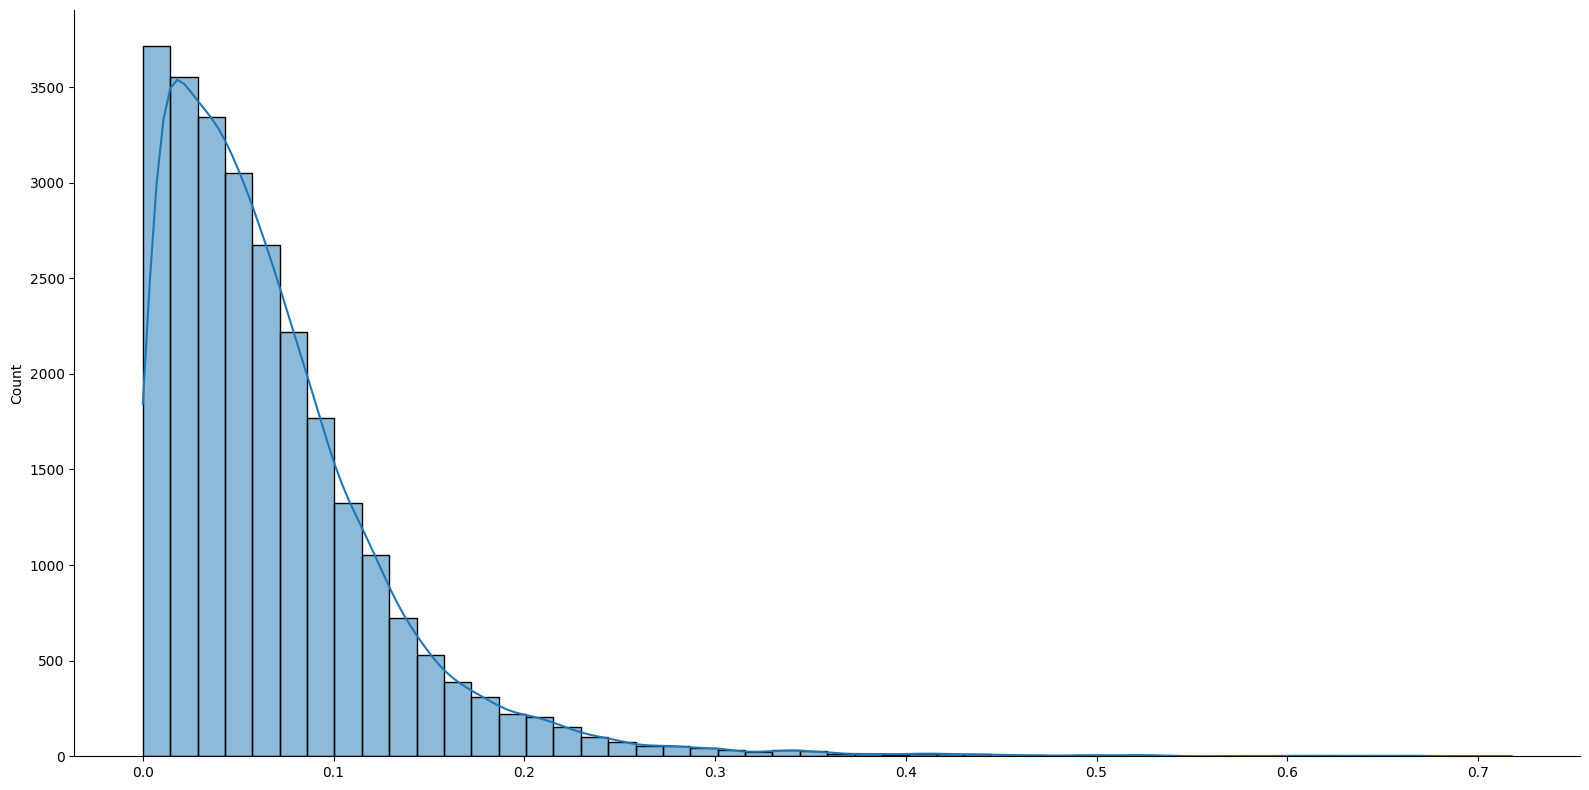

In [8]:
output_val = trainer.predict(model = anomaly_detector, dataloaders = dm.test_dataloader())
val_losses = []
for pred, loss in output_val:
    val_losses.extend(loss.numpy())
val_losses = np.array(val_losses)
sns.displot(val_losses, bins = 50, kde = True, height = 8, aspect = 2)
#plt.axvline(x = THRESHOLD, color = 'r', linestyle = '--', label = 'Threshold Escogido');

In [34]:
train_results = pd.DataFrame(val_losses, index = target_idx).reset_index().rename(columns = {0:'pred_loss', "index": "id"}).merge(train_df, on = "id", how = "left")
train_results.to_csv("../preds/train_preds_deepant.csv", index=False)

In [27]:
output = trainer.predict(anomaly_detector, dm)
pred_losses = []
for pred, loss in output:
    pred_losses.append(loss.numpy())

pred_losses = np.array(pred_losses)
len(pred_losses)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

,loss
0000_d-11,0.085215
0000_d-12,0.060724
0000_d-13,0.054204
0000_d-14,0.085742
0000_d-15,0.022278
...,...
0063_nd-264,0.049220
0063_nd-265,0.075291
0063_nd-266,0.074875
0063_nd-267,0.076240


In [30]:
pred_losses.shape, target_idx_val.shape # TODO: Chequear por qué tengo nulos en mis predicciones... 

((51800, 1), (51800,))

In [35]:
pred_results = pd.DataFrame(pred_losses, index = target_idx_val).dropna().reset_index().rename(columns = {0:'pred_loss', "index": "id"}).merge(val_df, on = "id", how = "left")
pred_results.to_csv("../preds/preds_deepant.csv", index=False)

## Thresholds

In [9]:
m_3sd, m_4sd, max_max = val_losses.mean() + 3*val_losses.std(), val_losses.mean() + 4*val_losses.std(), val_losses.max()
val_losses.mean(), val_losses.std()

(0.06808484, 0.06220648)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


A Jupyter Widget

51800

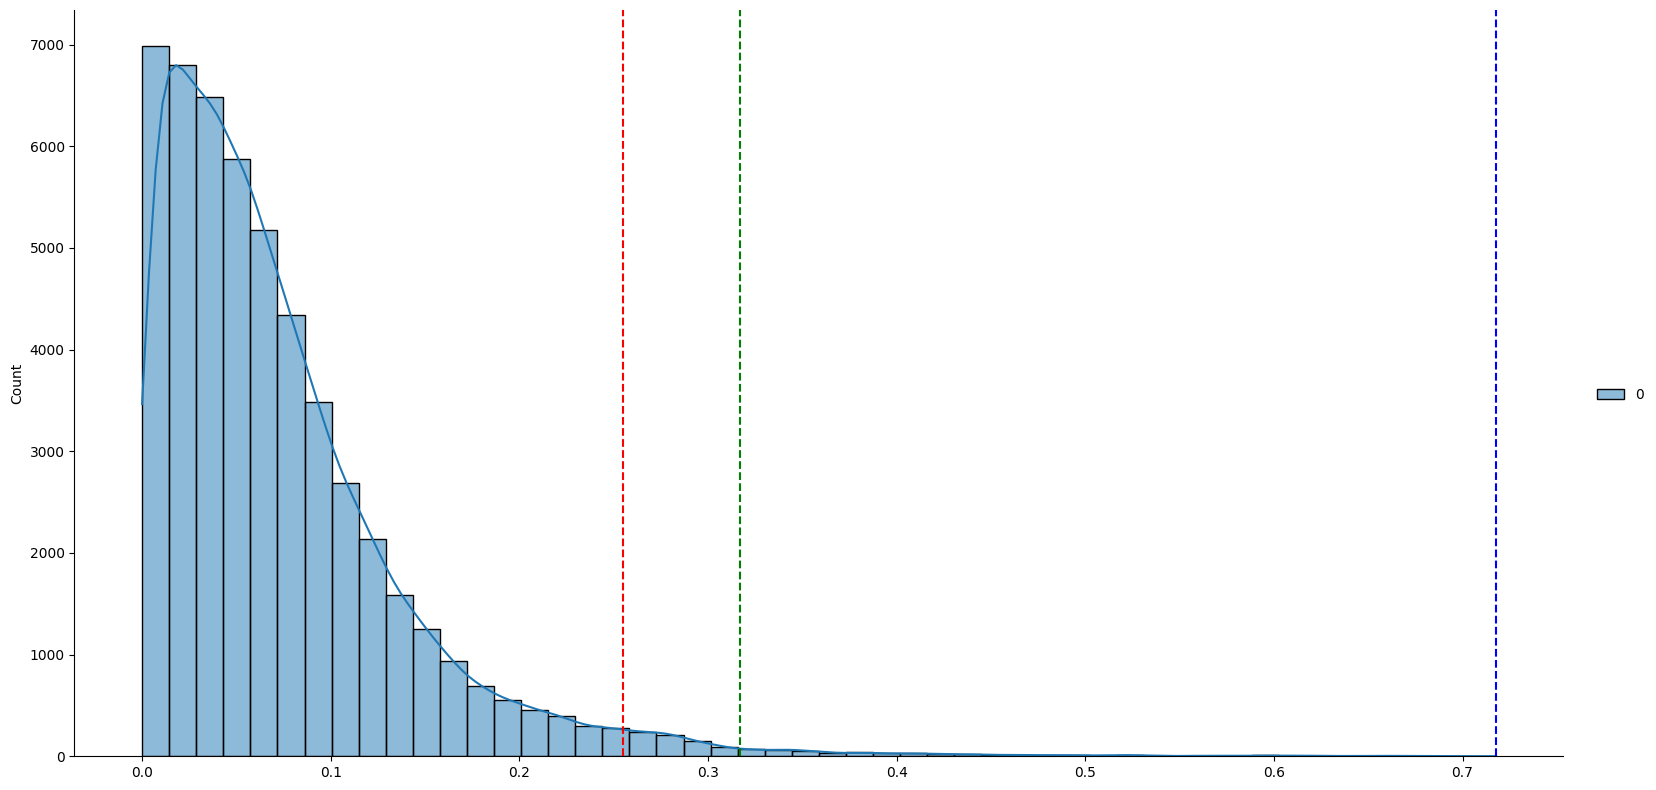

In [11]:
sns.displot(pred_losses, bins = 50, kde = True, height = 8, aspect = 2)
plt.axvline(x = m_3sd, color = 'r', linestyle = '--', label = 'Media más 3*SD')
plt.axvline(x = m_4sd, color = 'green', linestyle = '--', label = 'Media más 4*SD')
plt.axvline(x = max_max, color = 'blue', linestyle = '--', label = 'Máximo');

In [12]:
# THRESHOLD = 0.4
# def predict(trainer, model, dm, threshold):
#     output = trainer.predict(model, dm)
#     preds_losses = torch.tensor([item[1] for item in output]).numpy()
#     sns.displot(preds_losses, bins = 50, kde = True, height = 8, aspect = 2)
#     plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Threshold Escogido')
#     return preds_losses


# preds = pd.Series(predict(trainer, anomaly_detector, dm, threshold=THRESHOLD), index = target_idx)


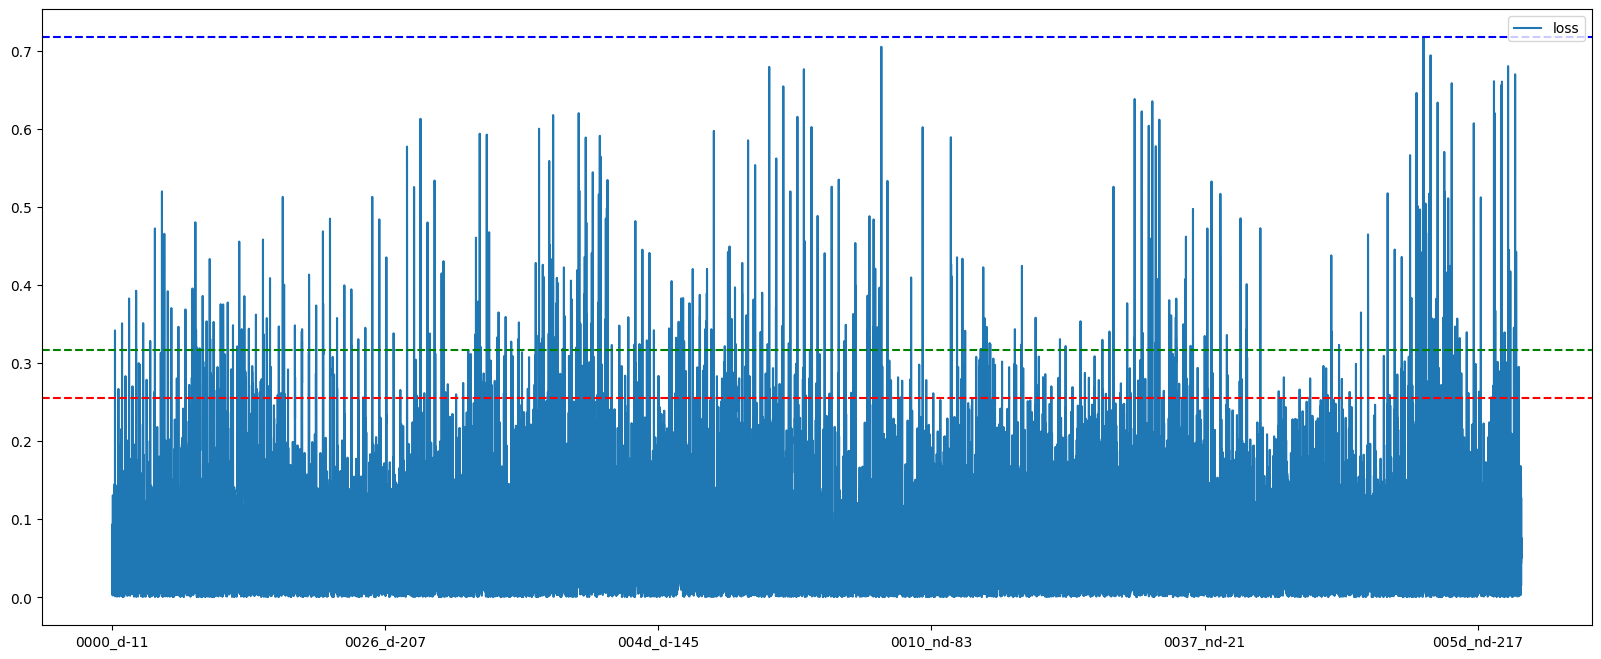

In [13]:
preds_df = pd.DataFrame(pred_losses, index = target_idx_val).dropna().rename(columns = {0:'loss'})
preds_df.plot(figsize = (20,8))
plt.axhline(y = m_3sd, color = 'r', linestyle = '--', label = 'Media más 3*SD')
plt.axhline(y = m_4sd, color = 'green', linestyle = '--', label = 'Media más 4*SD')
plt.axhline(y = max_max, color = 'blue', linestyle = '--', label = 'Máximo');

In [14]:
preds_df = preds_df.reset_index().rename(columns = {'index':'id'})
preds_df["ts_id"] = preds_df.id.str.split("-", expand=True)[0]
preds_df

,id,loss,ts_id
0,0000_d-11,0.085215,0000_d
1,0000_d-12,0.060724,0000_d
2,0000_d-13,0.054204,0000_d
3,0000_d-14,0.085742,0000_d
4,0000_d-15,0.022278,0000_d
...,...,...,...
51595,0063_nd-264,0.049220,0063_nd
51596,0063_nd-265,0.075291,0063_nd
51597,0063_nd-266,0.074875,0063_nd
51598,0063_nd-267,0.076240,0063_nd


In [15]:
idx = (preds_df["loss"] > m_3sd).reset_index(drop=True)
results_m_3sd = preds_df[idx].ts_id.drop_duplicates().str.split("_", expand=True)[1].value_counts()
results_m_3sd

d     99
nd    91
Name: 1, dtype: int64

In [16]:
def metrics(results):
    tp = results.loc["d"]
    fp = results.loc["nd"]
    tn = 100-results.loc["nd"]
    fn = 100-results.loc["d"]
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp /( tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

metrics(results_m_3sd)

(0.54, 0.5210526315789473, 0.99, 0.6827586206896552)

In [17]:
idx = (preds_df["loss"] > m_4sd).reset_index(drop=True)
results_m_4sd = preds_df[idx].ts_id.drop_duplicates().str.split("_", expand=True)[1].value_counts()
results_m_4sd

d     91
nd    64
Name: 1, dtype: int64

In [18]:
metrics(results_m_4sd)

(0.635, 0.5870967741935483, 0.91, 0.7137254901960784)

In [33]:
dates

[Timestamp('2009-06-30 00:00:00'),
 Timestamp('2018-02-28 00:00:00'),
 Timestamp('2018-03-31 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-31 00:00:00'),
 Timestamp('2018-06-30 00:00:00'),
 Timestamp('2019-05-31 00:00:00'),
 Timestamp('2019-06-30 00:00:00'),
 Timestamp('2019-07-31 00:00:00'),
 Timestamp('2019-08-31 00:00:00'),
 Timestamp('2019-09-30 00:00:00'),
 Timestamp('2019-11-30 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timestamp('2020-02-29 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-30 00:00:00'),
 Timestamp('2020-05-31 00:00:00'),
 Timestamp('2020-06-30 00:00:00'),
 Timestamp('2021-04-30 00:00:00'),
 Timestamp('2021-08-31 00:00:00')]

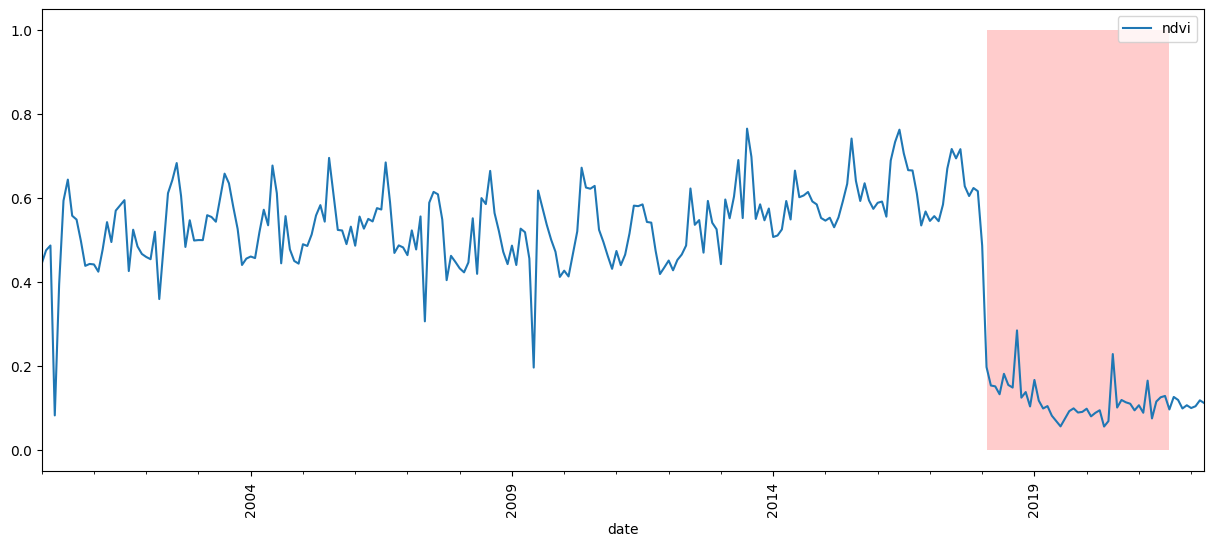

In [38]:
ide = "000b_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
#plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
#plt.fill_between(dates[0], dates[-1])
plt.fill_between(dates[1:], 0, 1, facecolor='red', alpha=.2)
plt.xticks(rotation=90);

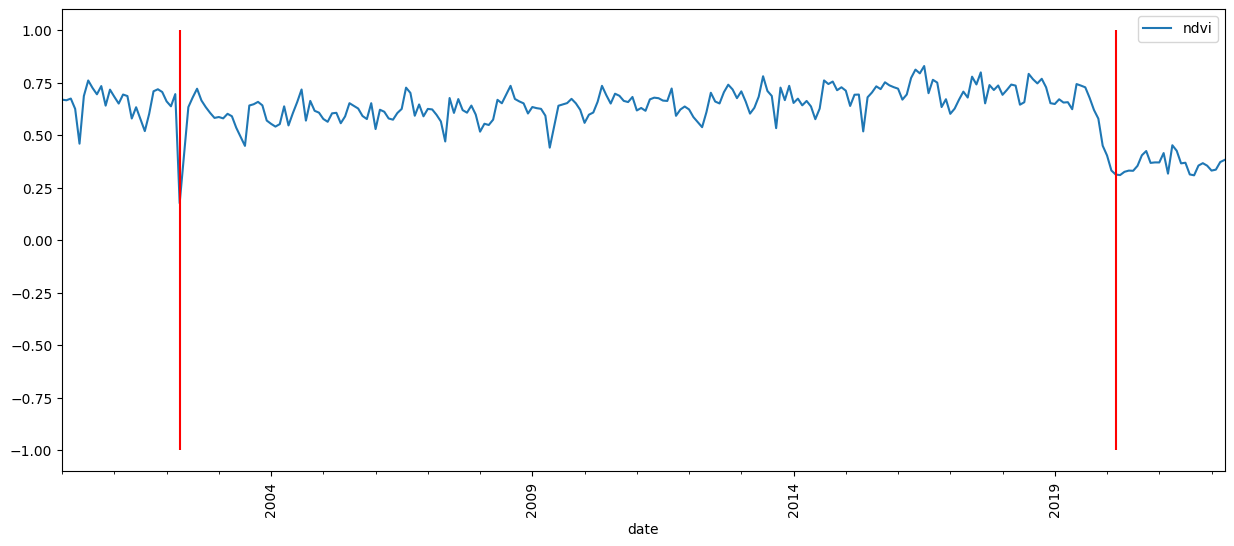

In [20]:
ide = "0006_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

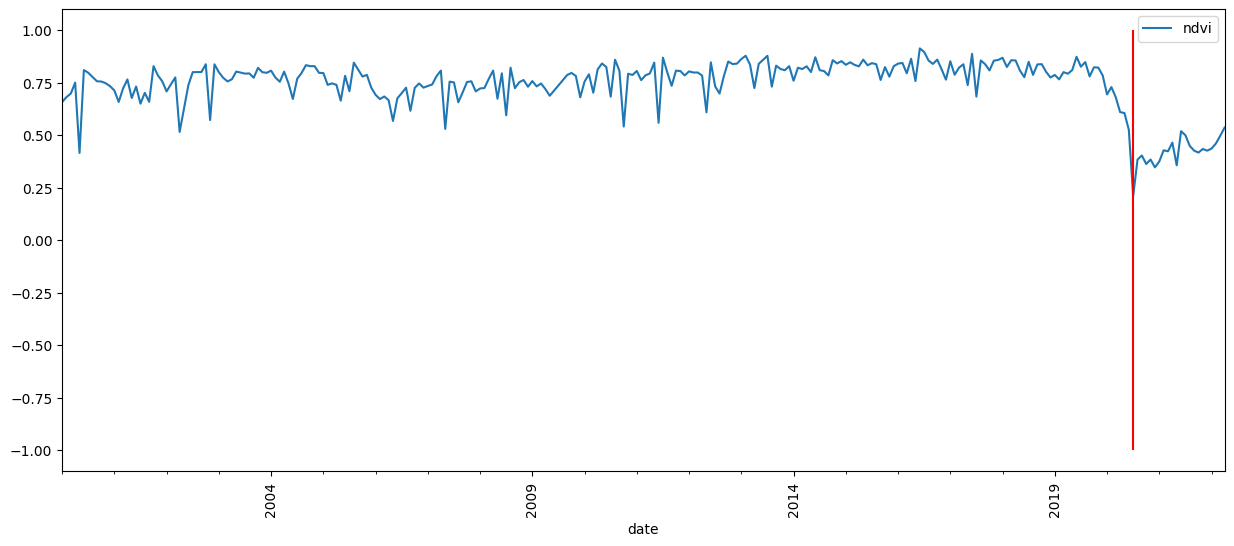

In [21]:
ide = "0025_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

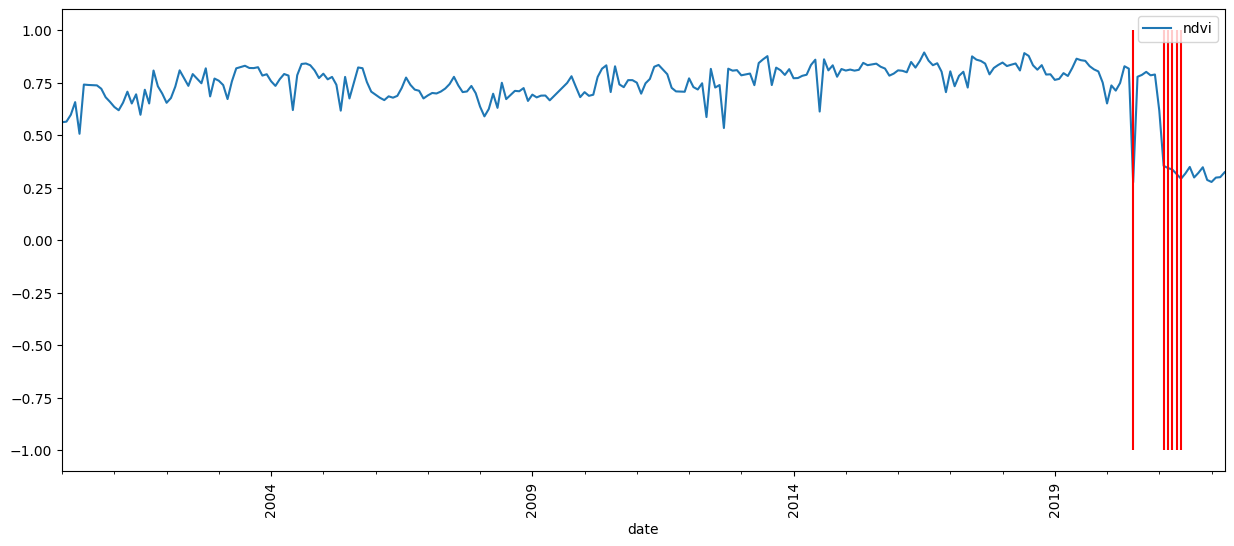

In [22]:
ide = "001d_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

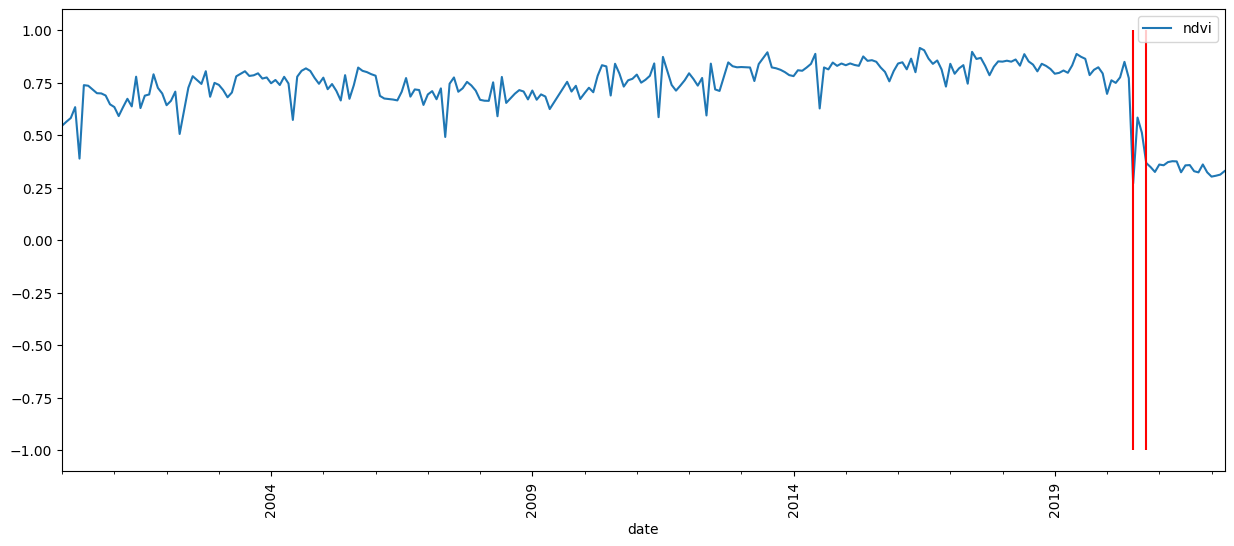

In [23]:
ide = "001e_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

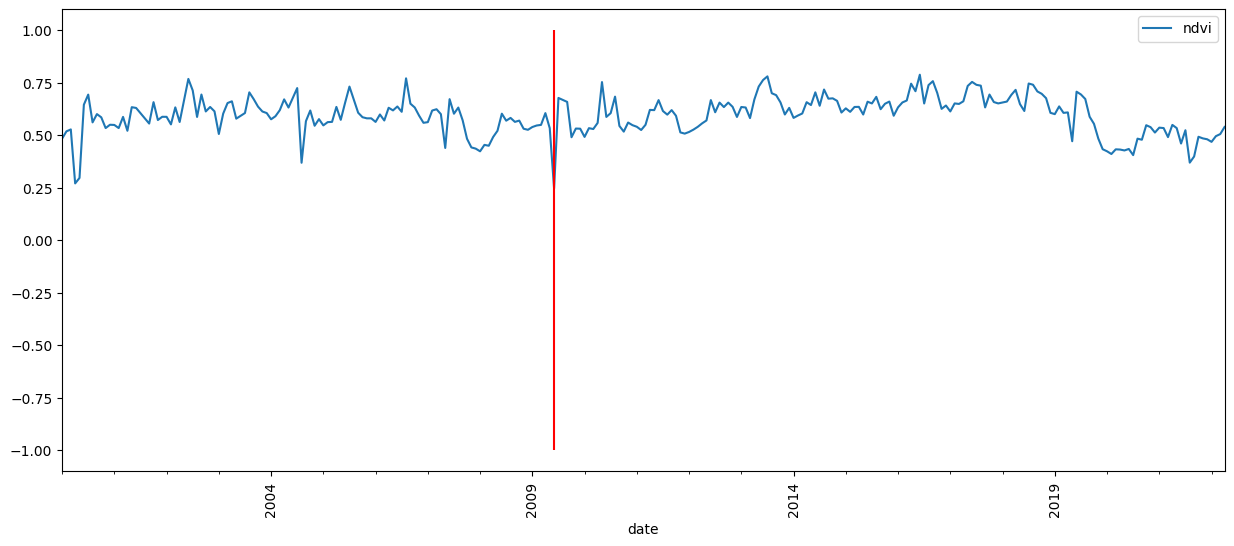

In [24]:
ide = "0009_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

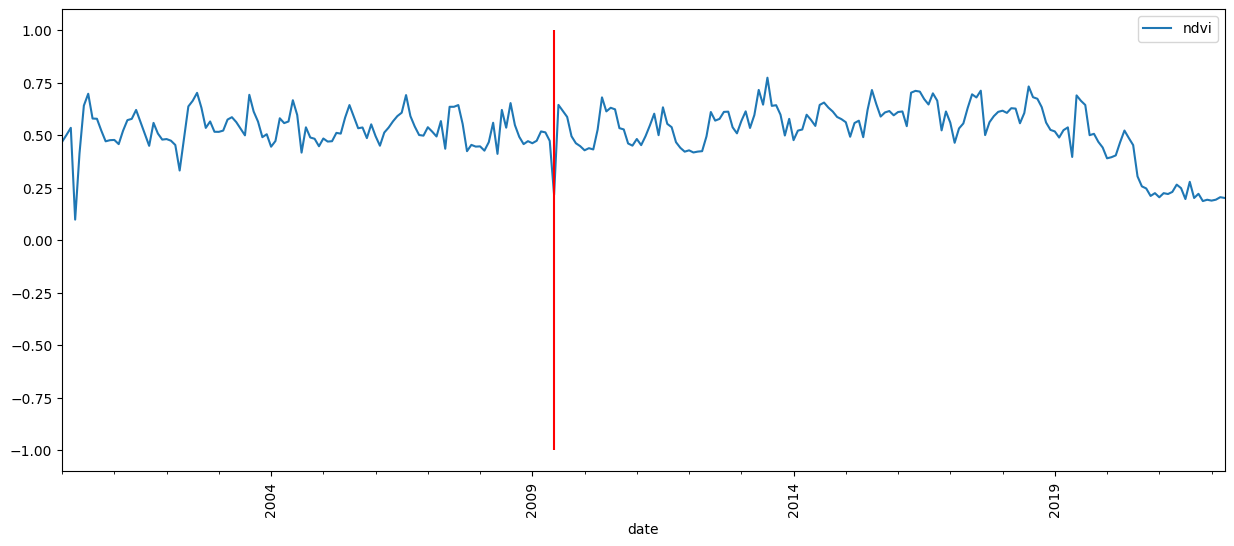

In [25]:
ide = "000a_d"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

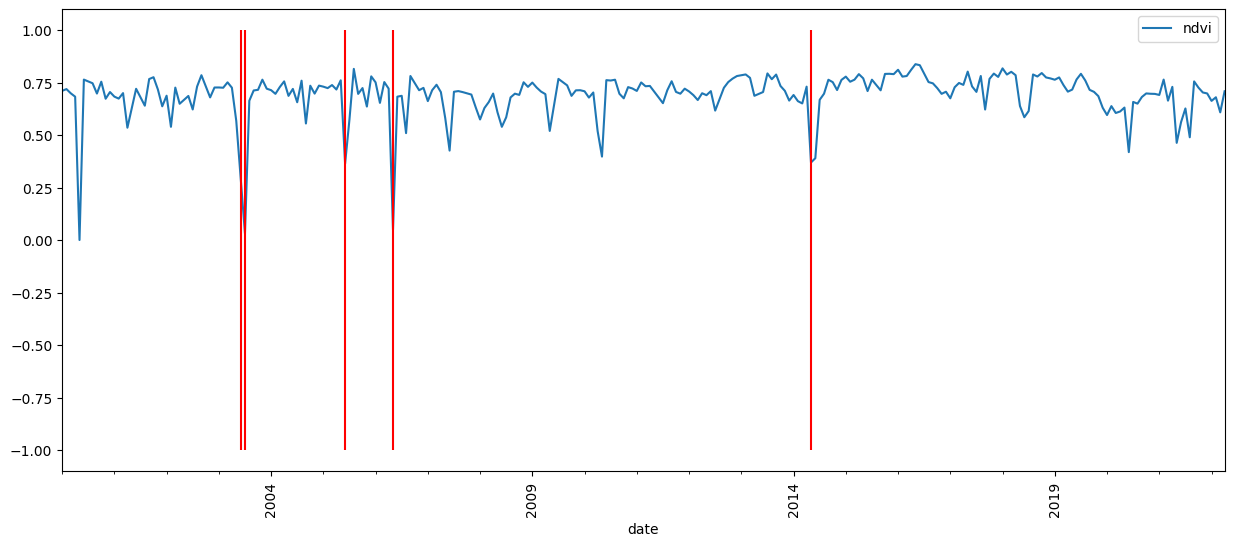

In [26]:
ide = "0061_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

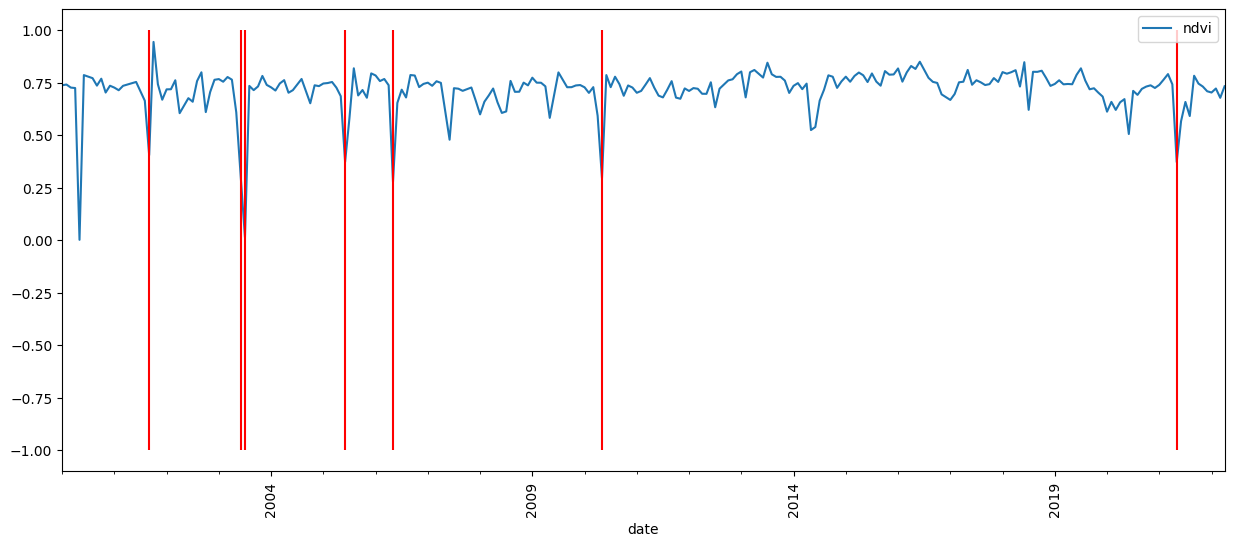

In [27]:
ide = "0062_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

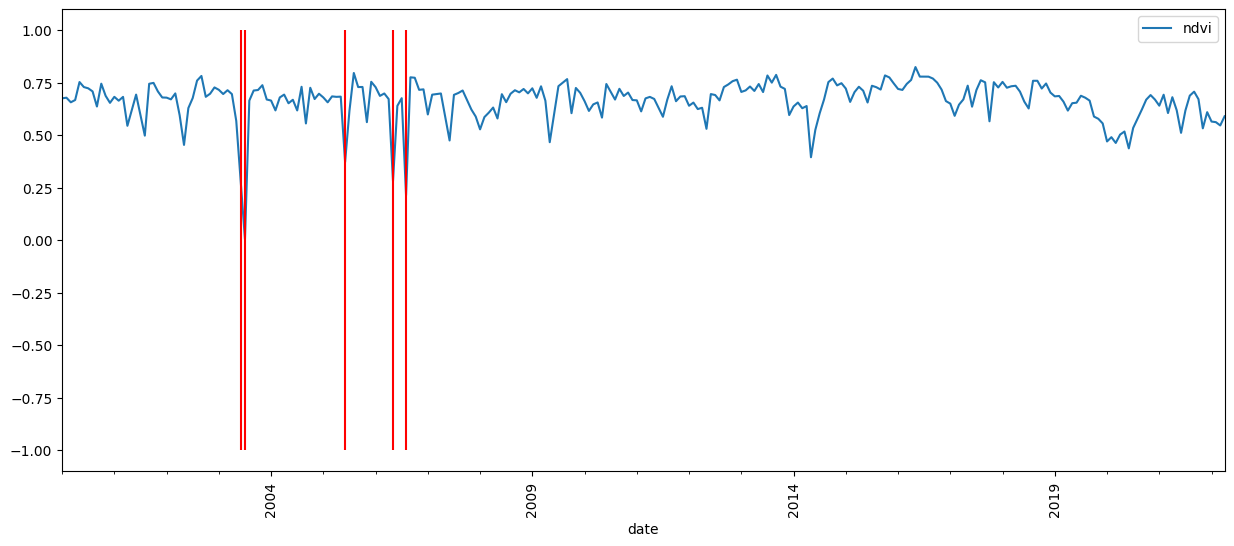

In [28]:
ide = "0063_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);

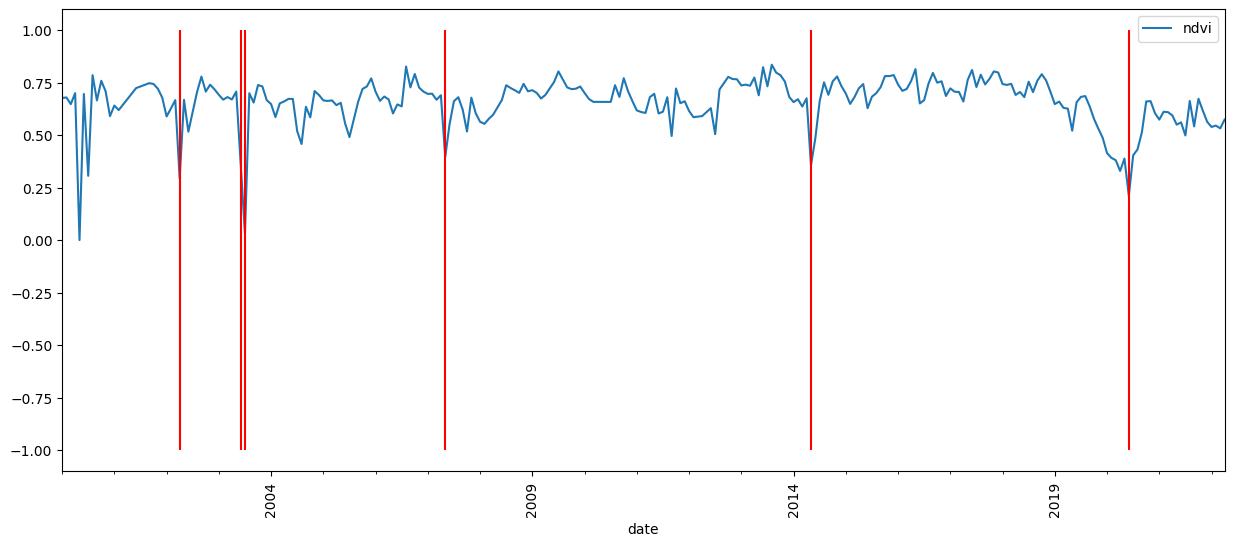

In [29]:
ide = "005a_nd"
val_df.query(f'ts_id == "{ide}"').set_index("date")[["ndvi"]].plot(figsize = (15,6))
ides = preds_df.query(f'ts_id == "{ide}" and loss > 0.3').id.tolist()
dates = val_df.query("id in @ides").date.tolist()
plt.vlines(x = dates, ymin = -1, ymax = 1, color = "red")
plt.xticks(rotation=90);